In [1]:

from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D
import pandas as pd

In [2]:
#Data Prep
data = pd.read_csv("/content/persons.csv",header=None)
data.columns = ["first","second","variation"]
print(data.shape)

(174218, 3)


In [3]:
data.head()

,first,second,variation
0,Mercia MacDermott,Mercia MacDermott,0
1,Mercia MacDermott,Mercia %28disambiguation%29,1
2,Euan Heng,Euan Heng,0
3,Euan Heng,Euan,0
4,Peter Gregg %28musician%29,Peter Gregg %28musician%29,0


In [4]:
data["merge"] = data["first"] + " " + data["second"]
data.head()

,first,second,variation,merge
0,Mercia MacDermott,Mercia MacDermott,0,Mercia MacDermott Mercia MacDermott
1,Mercia MacDermott,Mercia %28disambiguation%29,1,Mercia MacDermott Mercia %28disambiguation%29
2,Euan Heng,Euan Heng,0,Euan Heng Euan Heng
3,Euan Heng,Euan,0,Euan Heng Euan
4,Peter Gregg %28musician%29,Peter Gregg %28musician%29,0,Peter Gregg %28musician%29 Peter Gregg %28musi...


In [5]:

#list of charcaters
list_chars = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ%,.-/&' ")
print(len(list_chars))
tokens = {i:list_chars[i] for i in range(0,len(list_chars))}
tokens_rev = {list_chars[i]:i for i in range(0,len(list_chars))}
print(tokens)
print(tokens_rev)

70
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z', 36: 'A', 37: 'B', 38: 'C', 39: 'D', 40: 'E', 41: 'F', 42: 'G', 43: 'H', 44: 'I', 45: 'J', 46: 'K', 47: 'L', 48: 'M', 49: 'N', 50: 'O', 51: 'P', 52: 'Q', 53: 'R', 54: 'S', 55: 'T', 56: 'U', 57: 'V', 58: 'W', 59: 'X', 60: 'Y', 61: 'Z', 62: '%', 63: ',', 64: '.', 65: '-', 66: '/', 67: '&', 68: "'", 69: ' '}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35, 'A': 36, 'B': 37, 'C': 38, 'D': 39, 'E': 40, 'F': 41, 'G': 42

In [6]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(data[['first', 'second']], data['variation'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(111499, 2)
(111499,)
(27875, 2)
(27875,)
(34844, 2)
(34844,)


In [7]:
def character_onehot(column_list,tokens_rev):
  for i in range(0,len(column_list)):
    name_list_current = list(column_list[i])
    column_list[i] = [tokens_rev[char] for char in name_list_current]   
  return  column_list
#character_onehot(X_train['second'].to_list(),tokens_rev)

In [8]:
train_q1_seq = character_onehot(X_train['first'].to_list(),tokens_rev)
train_q2_seq = character_onehot(X_train['second'].to_list(),tokens_rev)
val_q1_seq = character_onehot(X_val['first'].to_list(),tokens_rev)
val_q2_seq = character_onehot(X_val['second'].to_list(),tokens_rev)
test_q1_seq = character_onehot(X_test['first'].to_list(),tokens_rev)
test_q2_seq = character_onehot(X_test['second'].to_list(),tokens_rev)

[[37, 14, 23, 24, 23, 18, 69, 37, 14, 17, 14, 34, 29], [48, 18, 27, 10, 23, 69, 37, 30, 33]]
max length =>  69


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


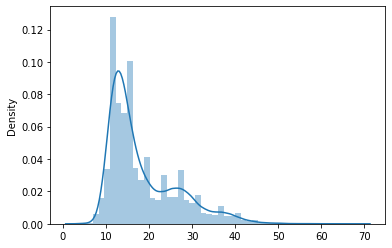

In [9]:
#Vector length for train q1
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

print(train_q1_seq[0:2])
len_vec = [len(char_vec) for char_vec in train_q1_seq]
print("max length => ", np.max(len_vec))
sns.distplot(len_vec)

[[37, 14, 23, 24, 23, 18, 69, 37, 14, 17, 14, 34, 29], [48, 18, 27, 10, 23]]
max length =>  69


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


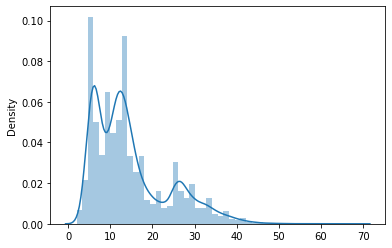

In [10]:
print(train_q2_seq[0:2])
len_vec = [len(char_vec) for char_vec in train_q2_seq]
print("max length => ", np.max(len_vec))
sns.distplot(len_vec)

In [11]:
from keras.preprocessing.sequence import pad_sequences
max_len = 50
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
print(train_q1_seq)

[[37 14 23 ...  0  0  0]
 [48 18 27 ...  0  0  0]
 [50 21 14 ...  0  0  0]
 ...
 [51 10 29 ...  0  0  0]
 [45 18 22 ...  0  0  0]
 [48 18 12 ...  0  0  0]]


In [12]:
import tensorflow as tf
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

In [13]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [14]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    try:
        return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
    except:
        pass

In [41]:
input_1 = Input(shape=(train_q1_seq.shape[1],))
input_2 = Input(shape=(train_q2_seq.shape[1],))


common_embed = Embedding(name="synopsis_embedd",input_dim =100, 
                       output_dim=30, 
                       input_length=train_q1_seq.shape[1],trainable=True) 
lstm_1 = common_embed(input_1)
lstm_2 = common_embed(input_2)


common_lstm = LSTM(64,return_sequences=True, activation="relu")
vector_1 = common_lstm(lstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_lstm(lstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

model.compile(loss="binary_crossentropy",metrics=['accuracy'], optimizer=Adam(0.00001))

In [42]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
synopsis_embedd (Embedding)     (None, 50, 30)       3000        input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 50, 64)       24320       synopsis_embedd[0][0]      

In [43]:
model.fit([train_q1_seq,train_q2_seq],y_train.values.reshape(-1,1), epochs = 30,
          batch_size=43,validation_data=([val_q1_seq, val_q2_seq],y_val.values.reshape(-1,1)))

Epoch 1/30
2593/2593 [==============================] - 155s 59ms/step - loss: 0.6161 - accuracy: 0.8772 - val_loss: 0.4083 - val_accuracy: 0.9642
Epoch 2/30
2593/2593 [==============================] - 151s 58ms/step - loss: 0.3943 - accuracy: 0.9624 - val_loss: 0.3490 - val_accuracy: 0.9669
Epoch 3/30
2593/2593 [==============================] - 152s 59ms/step - loss: 0.3374 - accuracy: 0.9665 - val_loss: 0.2982 - val_accuracy: 0.9687
Epoch 4/30
2593/2593 [==============================] - 153s 59ms/step - loss: 0.2883 - accuracy: 0.9675 - val_loss: 0.2554 - val_accuracy: 0.9692
Epoch 5/30
2593/2593 [==============================] - 152s 59ms/step - loss: 0.2425 - accuracy: 0.9684 - val_loss: 0.2142 - val_accuracy: 0.9693
Epoch 6/30
2593/2593 [==============================] - 153s 59ms/step - loss: 0.2056 - accuracy: 0.9675 - val_loss: 0.1747 - val_accuracy: 0.9712
Epoch 7/30
2593/2593 [==============================] - 152s 59ms/step - loss: 0.1725 - accuracy: 0.9693 - val_loss: 0

In [66]:
first_term = character_onehot(["Vikas Nair"],tokens_rev)
second_term = character_onehot(["Vikas Nayar"],tokens_rev)
first_padded = pad_sequences(first_term, maxlen=max_len, padding='post')
second_padded = pad_sequences(second_term, maxlen=max_len, padding='post')


In [67]:
model.predict([first_padded,second_padded])

array([[0.04597953]], dtype=float32)